In [30]:
modelPath = "Clickbait"
checkpoint = "cmarkea/distilcamembert-base"   # cmarkea/distilcamembert-base-sentiment "cmarkea/distilcamembert-base" "camembert-base" "microsoft/Multilingual-MiniLM-L12-H384"
problem_type =  "single_label_classification" # Valeurs possibles : "regression", "single_label_classification", "multi_label_classification"
num_labels = 3                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
LCfraction = 'truthMean'                      # 'LCFraction'
removeColumns = ['postText', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'id', 'truthMean', 'attention_mask'] # Il faut enlever les colonnes de type texte
splitFactor = 0.1                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import CamembertTokenizerFast, CamembertTokenizer
from transformers import AutoConfig

In [4]:
# checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"
# checkpoint = "cmarkea/distilcamembert-base"
# checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
# checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type, # on pourra enlever ce paramètre si ca marche plus
   num_labels = num_labels)
# model = BertForSequenceClassification.from_pretrained(checkpoint,
# problem_type="multi_label_classification", # ne sert à rien ?
# num_labels = 5                             # 5 est la seule valeur possible

Some weights of the model checkpoint at cmarkea/distilcamembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at cmarkea/distilcamembert-base and are newly initialized: ['classifier.dense.bias', 'classif

In [5]:
import datasets as ds

In [31]:
curated = ds.load_from_disk(dataCuratedPath)

In [32]:
longueur= len(curated)

In [33]:
trie=sorted(curated[LCfraction])

In [34]:
import matplotlib.pyplot as plt

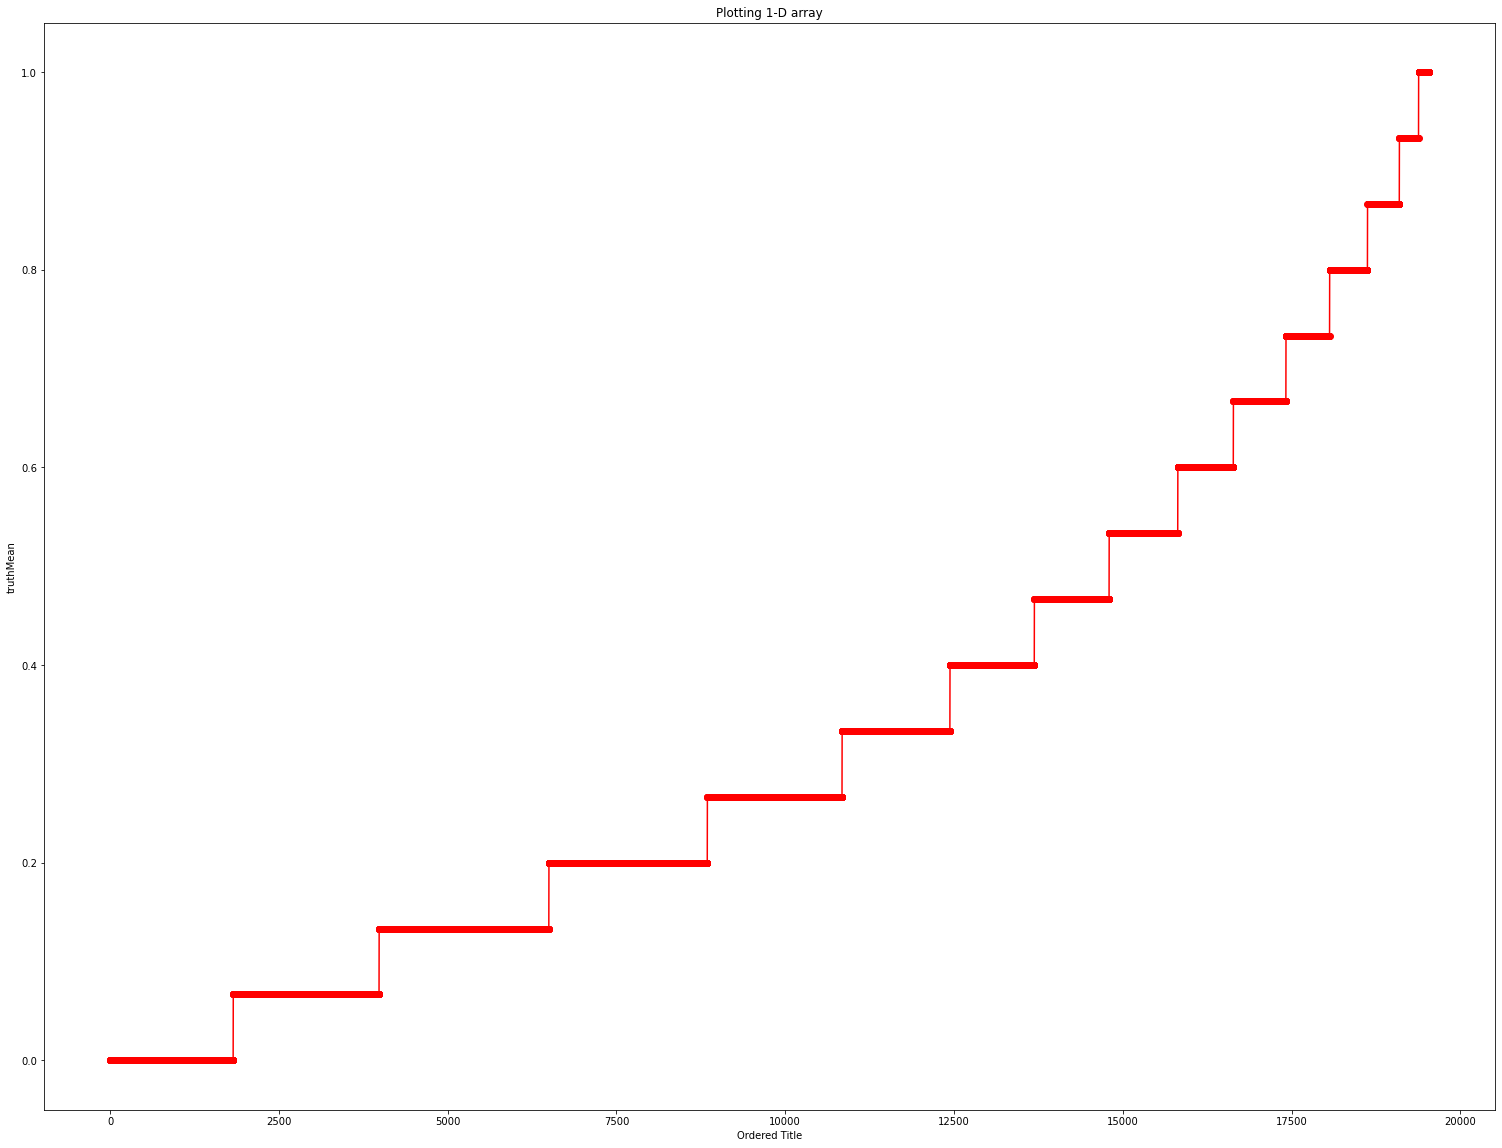

In [35]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(LCfraction)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "red", marker = "o", label = "Array elements")

In [36]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[0.199999999979999, 0.399999999979999]

In [148]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample['postText'],  #+ ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            padding=True,
            truncation=True,
            max_length=30)
    fraction = sample[LCfraction]
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    return tokenized_sample

In [149]:
tokenized_curated = curated.map(tokenize) #, batched=True)

Loading cached processed dataset at Data/Curated\cache-dcfb92c3de1ccb1c.arrow


In [150]:
tokenized_curated

Dataset({
    features: ['postText', 'id', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'truthMean', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 19538
})

In [151]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

Loading cached split indices for dataset at Data/Curated\cache-00bc6830c2050202.arrow and Data/Curated\cache-ec635c58374c615a.arrow


In [152]:
tokenized_curated4 = tokenized_curated3

In [153]:
tokenized_curated4.set_format("torch")

In [155]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [156]:
from transformers import TrainingArguments

In [157]:
from datasets import load_metric

In [158]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [159]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [160]:
training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 8,
                                  optim= 'adamw_torch',
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [161]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_curated4["train"],
    eval_dataset=tokenized_curated4["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)] #3
    # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
)

In [162]:
# faire la boucle avec le trainer pytorch
trainer.train()

***** Running training *****
  Num examples = 17584
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17584


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.